# Particle Analysis

This notebook uses the OpenCV python package to extract the particle sizes from a several high angle annular dark field (HAADF) images contained in the `Images` folder. It outputs csv files containing the raw data and summary histograms to the `Output` folder.

Notebook written by Ondrej Dyck

January 20, 2023

In [1]:
# import packages

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

Get image names

In [17]:
image_folder = 'Images'
image_names = os.listdir(image_folder)
image_names

['SuperScan (HAADF) 45.bmp',
 'SuperScan (HAADF) 47.bmp',
 'SuperScan (HAADF) 42.bmp',
 'SuperScan (HAADF) 38.bmp',
 'SuperScan (HAADF) 48.bmp',
 'SuperScan (HAADF) 41.bmp',
 'SuperScan (HAADF) 44.bmp',
 'SuperScan (HAADF) 49.bmp']

Read all the images

In [18]:
images = []
for name in image_names:
    full_name = os.path.join(image_folder, name)
    images.append(cv2.imread(full_name, cv2.IMREAD_GRAYSCALE))


Plot the images

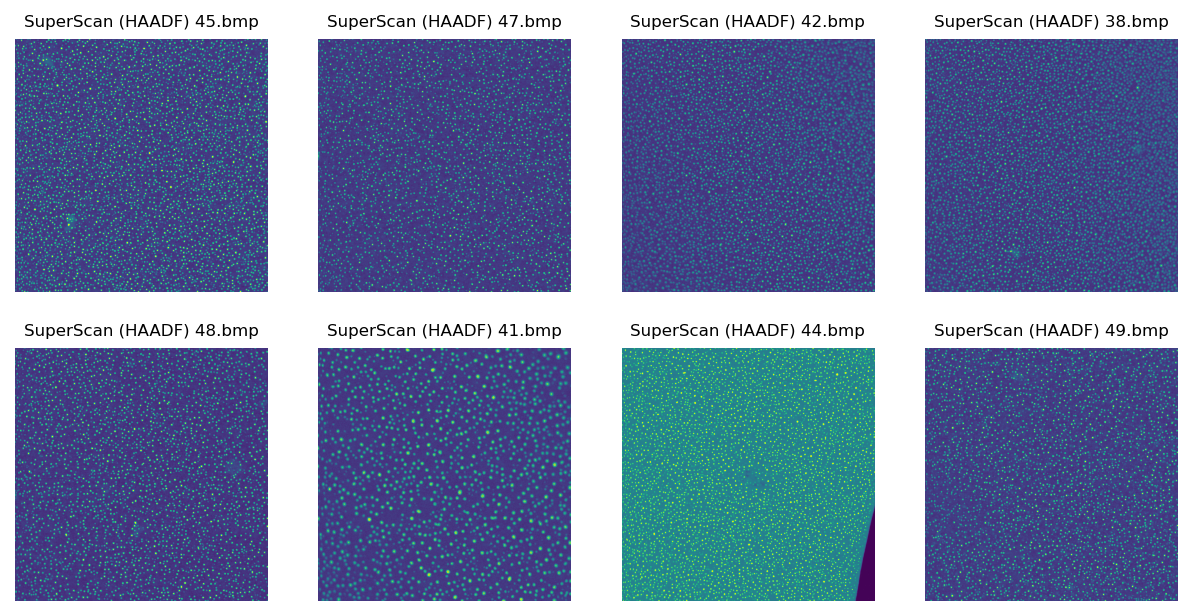

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10,5), facecolor='white', dpi=150)

for image, axis, name in zip(images, np.ravel(ax), image_names):
    axis.imshow(image)
    axis.set_title(name, fontsize=8)
    axis.set_axis_off()

plt.show()

All of the images were acquired at the same magnification/resolution except for image `SuperScan (HAADF) 41.bmp`. To ensure the correct areas are extracted we need to make sure to apply the correct scaling for each image. Likewise, the threshold for `SuperScan (HAADF) 44.bmp` will need to be different from the rest because of the dark vacuum signal on the corner. 

In [22]:
# this dictionary stores the pixel area for each image in nm^2
scale_dict = {'SuperScan (HAADF) 45.bmp': 1.0,
                'SuperScan (HAADF) 47.bmp': 1.0,
                'SuperScan (HAADF) 42.bmp': 1.0,
                'SuperScan (HAADF) 38.bmp': 1.0,
                'SuperScan (HAADF) 48.bmp': 1.0,
                'SuperScan (HAADF) 41.bmp': 0.25,
                'SuperScan (HAADF) 44.bmp': 1.0,
                'SuperScan (HAADF) 49.bmp': 1.0}

# this dictionary stores the thresholds we will use
thresh_dict = {'SuperScan (HAADF) 45.bmp': 80,
                'SuperScan (HAADF) 47.bmp': 80,
                'SuperScan (HAADF) 42.bmp': 80,
                'SuperScan (HAADF) 38.bmp': 80,
                'SuperScan (HAADF) 48.bmp': 80,
                'SuperScan (HAADF) 41.bmp': 80,
                'SuperScan (HAADF) 44.bmp': 150,
                'SuperScan (HAADF) 49.bmp': 80}


The following function performs the analysis. The rest of the code handles setup, plotting, and saving details.

In [21]:
def find_particles(image, image_name, pixel_area, threshold):

    # threshold the image
    ret, thresh = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

    # find contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # get the area within each contour
    areas = []
    for i in range(0, len(contours)):
        areas.append(cv2.contourArea(contours[i])*pixel_area)
    
    # put the data into a Pandas DataFrame
    base = image_name.rsplit('.')[0]
    data = {'name': [base]*len(areas), 'area': areas}
    df = pd.DataFrame(data)

    # remove zeros
    df = df[df['area']>0.0]

    return df

Loop through the images and call the `find_particles` function

In [23]:
list_of_dataframes = []
for image, image_name in zip(images, image_names):
    df = find_particles(image, image_name, scale_dict[image_name], thresh_dict[image_name])
    list_of_dataframes.append(df)

We now have the analysis results in a list of Pandas DataFrames. We will save the output to CSV files in the output folder.

Warning: Execution of the following cell will silently overwrite previous outputs. To prevent this, change the output file name.

In [28]:
out_folder = 'Output'
for df, name in zip(list_of_dataframes, image_names):
    basename = name.rsplit('.')[0]
    full_name = os.path.join(out_folder, basename+'.csv')
    df.to_csv(full_name, index=False)

Plot histograms of the results

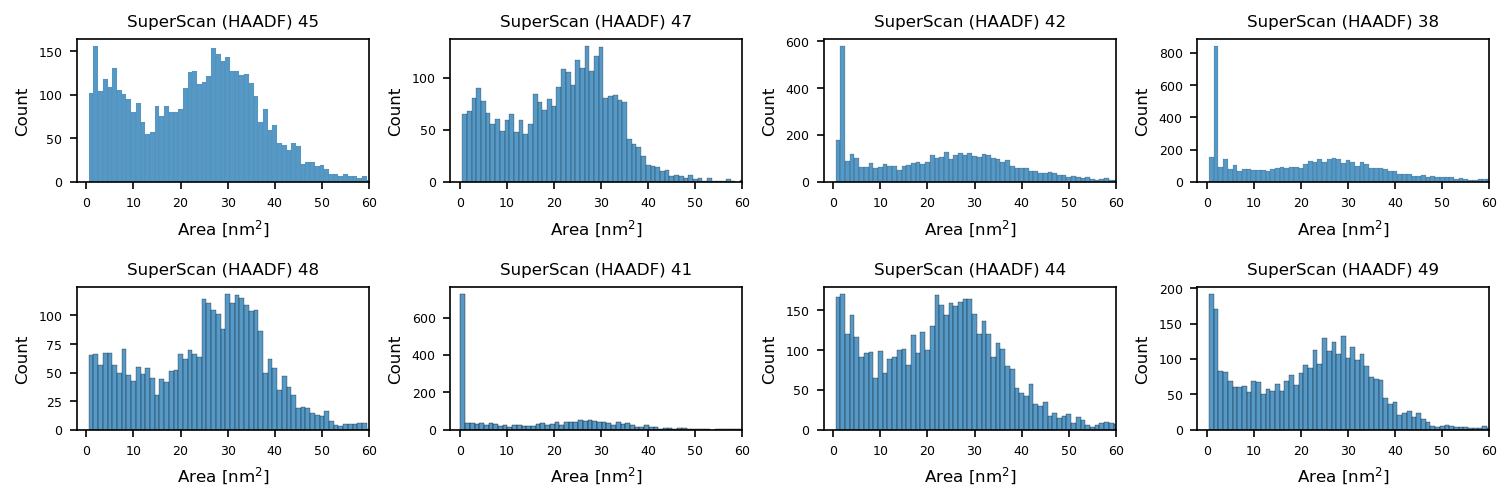

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10,3), facecolor='white', dpi=150)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=3.0)

for df, axis, name in zip(list_of_dataframes, np.ravel(ax), image_names):
    sns.histplot(df['area'], kde=False, binwidth=1, ax=axis)
    base = name.rsplit('.')[0]
    axis.set_title(base, fontsize=8)
    axis.set_xlabel('Area [nm$^2$]', fontsize=8)
    axis.set_ylabel('Count', fontsize=8)
    axis.set_xlim(-2,60)
    axis.tick_params(labelsize=6)

plt.show()

Finally, let's save a plot of each one (separately) in the output folder. Note, the output format can be changed by simply changing the file extension `.svg` to, for example, `.png`. This cell also silently overwrites previous output.

In [43]:
for df, name in zip(list_of_dataframes, image_names):

    sns.histplot(df['area'], kde=False, binwidth=1)
    base = name.rsplit('.')[0]
    plt.title(base, fontsize=25)
    plt.xlabel('Area [nm$^2$]', fontsize=20)
    plt.ylabel('Count', fontsize=20)
    plt.xlim(-2,60)
    plt.tick_params(labelsize=15)
    savename = base+'_hist.svg'
    full_name = os.path.join(out_folder, savename)
    plt.savefig(full_name, bbox_inches='tight')
    plt.close()


The analysis of the combined data can be found in the `Combining_data.ipynb` notebook.